# Dataset Exploration: Suicide_Detection.csv

This notebook performs a full exploratory data analysis (EDA) on the raw dataset located at `data/raw/Suicide_Detection.csv`.

Sections:
- Imports and load data
- Basic overview (shape, columns, dtypes, head)
- Missing values and summary statistics
- Target detection and class balance
- Text column detection, text-length distribution and top words
- Visualizations and next steps

In [1]:
# Imports: standard EDA libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# plotting defaults
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Locate and load the CSV file
data_path = Path('..') / 'data' / 'raw' / 'Suicide_Detection.csv'
# if running from repo root in Notebook, adjust path: try both local and repo-root aware
if not data_path.exists():
    data_path = Path('data') / 'raw' / 'Suicide_Detection.csv'
print('Using data file:', data_path)

# read with pandas (let pandas infer encoding/types). If file is large, consider nrows preview first.
df = pd.read_csv(data_path)
print('Loaded, shape:', df.shape)

Using data file: ../data/raw/Suicide_Detection.csv


Loaded, shape: (232074, 3)


In [3]:
# Basic overview
display(df.head(10))
print('\nColumns and dtypes:')
display(pd.DataFrame({'column': df.columns, 'dtype': df.dtypes.astype(str)}))

print('\nDataFrame info:')
df.info()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide



Columns and dtypes:


,column,dtype
Unnamed: 0,Unnamed: 0,int64
text,text,object
class,class,object



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [4]:
# Summary statistics for numeric columns
display(df.describe(include='number').T)

# Summary for object / categorical columns (top / freq)
display(df.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,232074.0,174152.863518,100500.425362,2.0,87049.25,174358.5,261285.75,348110.0


,count,unique,top,freq
text,232074,232074,Ex Wife Threatening SuicideRecently I left my ...,1
class,232074,2,suicide,116037


In [5]:
# Missing values: counts and percentage
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({'missing_count': missing, 'missing_percent': missing_pct})
display(missing_table[missing_table['missing_count']>0])

# Visualize missingness if there are any missing values
if missing_table['missing_count'].sum() > 0:
    plt.figure(figsize=(10, max(2, 0.3 * missing_table.shape[0])))
    sns.heatmap(df.isna(), cbar=False)
    plt.title('Missing values heatmap (rows x columns)')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()
else:
    print('No missing values detected')

,missing_count,missing_percent


No missing values detected


Detected target column: class


,count
class,
suicide,116037
non-suicide,116037


,percent
class,
suicide,50.0
non-suicide,50.0


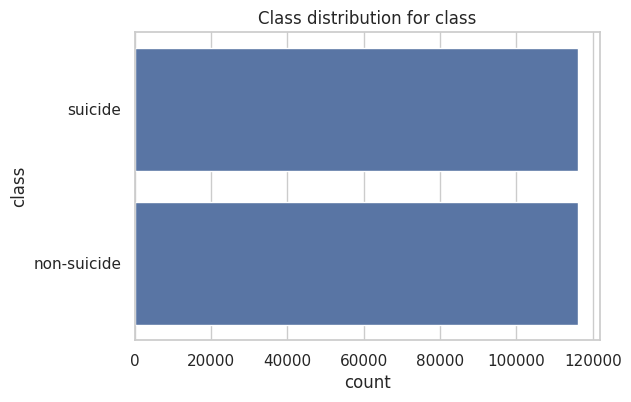

In [6]:
# Attempt to detect a target / label column automatically
# Heuristics: columns named 'label','target','class','suicide' or columns with small unique values (<=10) and type int/object.
possible_names = ['label','target','class','suicide','suicidal']
target_col = None
for name in possible_names:
    if name in df.columns:
        target_col = name
        break
if target_col is None:
    # look for low-cardinality columns (but not an id column)
    for c in df.columns:
        if (df[c].nunique(dropna=False) <= 10) and (df[c].nunique() > 1):
            # avoid columns that look like ids (unique for each row)
            if df[c].nunique() / len(df) < 0.95:
                target_col = c
                break

print('Detected target column:', target_col)
if target_col is not None:
    vc = df[target_col].value_counts(dropna=False)
    display(vc.to_frame(name='count'))
    display((vc / len(df) * 100).round(2).to_frame(name='percent'))
    # plot class distribution
    plt.figure(figsize=(6,4))
    sns.countplot(y=target_col, data=df, order=vc.index)
    plt.title('Class distribution for ' + str(target_col))
    plt.xlabel('count')
    plt.show()
else:
    print('No clear target column detected automatically. Consider specifying it manually.')

In [7]:
# Detect likely text columns (object dtype with relatively long contents)
text_candidates = []
for c in df.select_dtypes(include=['object']).columns:
    median_len = df[c].dropna().astype(str).map(len).median() if df[c].notna().any() else 0
    mean_len = df[c].dropna().astype(str).map(len).mean() if df[c].notna().any() else 0
    if mean_len > 20 or median_len > 10:
        text_candidates.append((c, int(mean_len), int(median_len)))

print('Text column candidates (column, mean_len, median_len):')
display(pd.DataFrame(text_candidates, columns=['column','mean_len','median_len']))

Text column candidates (column, mean_len, median_len):


,column,mean_len,median_len
0,text,689,315


Using text column: text


,text_length_stats
count,232074.000000
mean,689.639736
std,1156.334007
min,3.000000
25%,138.000000
50%,315.000000
75%,801.000000
max,40297.000000


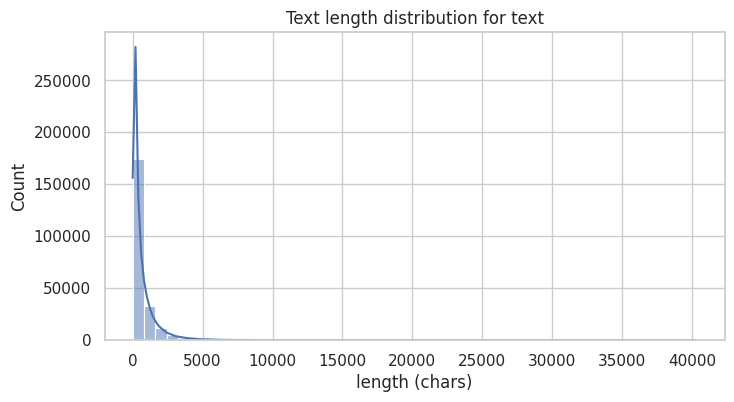

,word,count
0,just,258087
1,don,189216
2,like,182197
3,want,148885
4,know,131662
5,feel,122698
6,life,122686
7,ve,120178
8,people,95243
9,time,87592


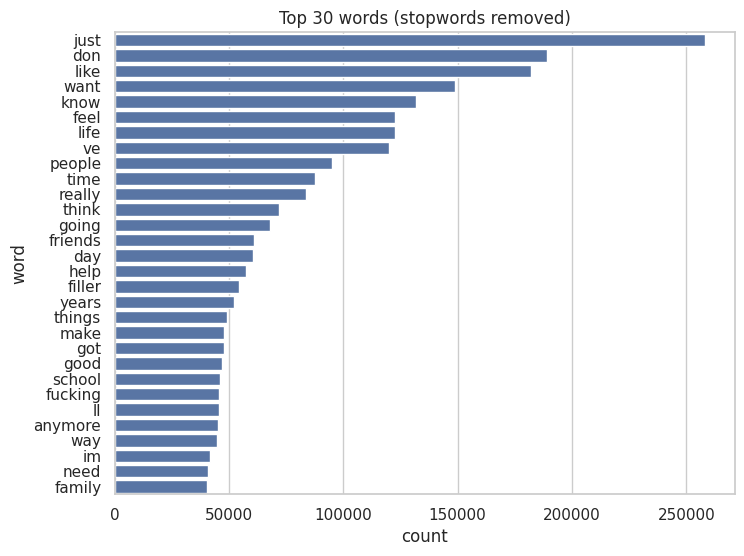


Top words for class suicide:


,word,count
0,just,204419
1,don,159963
2,like,131636
3,want,128367
4,life,113053
5,feel,108126
6,know,106737
7,ve,105674
8,people,73096
9,time,70863



Top words for class non-suicide:


,word,count
0,filler,54601
1,just,53668
2,like,50561
3,don,29253
4,know,24925
5,people,22147
6,fuck,21525
7,want,20518
8,day,18801
9,really,18425


In [8]:
# If we found a text column, show length distribution and top words
if text_candidates:
    text_col = text_candidates[0][0]
    print('Using text column:', text_col)
    # text length distribution
    lengths = df[text_col].dropna().astype(str).map(len)
    display(lengths.describe().to_frame(name='text_length_stats'))
    plt.figure(figsize=(8,4))
    sns.histplot(lengths, bins=50, kde=True)
    plt.title('Text length distribution for ' + text_col)
    plt.xlabel('length (chars)')
    plt.show()

    # Top words overall (simple)
    vect = CountVectorizer(stop_words='english', max_features=2000)
    docs = df[text_col].fillna('').astype(str)
    X = vect.fit_transform(docs)
    word_counts = np.array(X.sum(axis=0)).ravel()
    vocab = np.array(vect.get_feature_names_out())
    top_idx = np.argsort(word_counts)[-30:][::-1]
    top_words = pd.DataFrame({'word': vocab[top_idx], 'count': word_counts[top_idx]})
    display(top_words)
    plt.figure(figsize=(8,6))
    sns.barplot(data=top_words, y='word', x='count')
    plt.title('Top 30 words (stopwords removed)')
    plt.show()

    # Top words by class if target found
    if target_col is not None:
        for cls in df[target_col].dropna().unique():
            mask = df[target_col] == cls
            docs_cls = df.loc[mask, text_col].fillna('').astype(str)
            Xc = vect.transform(docs_cls)
            wc = np.array(Xc.sum(axis=0)).ravel()
            top_idx_c = np.argsort(wc)[-15:][::-1]
            print(f'\nTop words for class {cls}:')
            display(pd.DataFrame({'word': vocab[top_idx_c], 'count': wc[top_idx_c]}))
else:
    print('No text-like column detected automatically. If your text column is named differently, set text_col manually and re-run analysis.')

## Quick conclusions and suggested next steps

- Review the detected `target_col` above — if it's incorrect, set `target_col = '<your_column>'` and re-run the class-balance and top-words cells.
- If there are missing values in important columns, decide on imputation or row removal strategies.
- For text processing: clean punctuation, lowercase, consider lemmatization, and try TF-IDF or embeddings for modelling.
- If classes are imbalanced: consider stratified splits, resampling, or class-weighted models.
- Save a cleaned subset for model development under `data/processed/` after you finalize preprocessing choices.